In [1]:
import os 
import re
from typing import List
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from anbe_tool.plotting import method_pal

In [2]:
plt.style.use('jr')

In [3]:
plt.style.use('default')
plt.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams['pdf.fonttype'] = 42 

# Metrics from all samples


In [4]:
def sort_df(df, key):
    df['method_cat'] = df.method.astype("category")
    df.method_cat = df.method_cat.cat.set_categories(key)
    return df.sort_values('method_cat')

In [5]:
metric_tbl = pd.read_excel("../../results/model_runs/bean_count_LDLvar_annotated_complete/splicing.metrics.xlsx", sheet_name=0)
metric_tbl_lm = pd.read_excel("../../results/model_runs/bean_count_LDLvar_annotated_complete/strongest_splicing.metrics.xlsx", sheet_name=0)

In [6]:
bean_method_label_map = {
    "MixtureNormal": "CRISPR-Bean: reporter",
    "MixtureNormal+Acc": "CRISPR-Bean: reporter+acc",
    "Normal": "CRISPR-Bean: perfect",
}
def method_label_map(label):
    if label in bean_method_label_map.keys():
        return bean_method_label_map[label]
    label = label.replace("MAGeCK-RRA_bot", "MAGeCK-RRA")
    if "MAGeCK-MLE_sort" in label:
        label = label.replace("MAGeCK-MLE_sort_var_", "MAGeCK-MLE").replace("MAGeCK-MLE_sort_", "MAGeCK-MLE(sort) ")
        label = label.replace("EM", "+edit rate")
        label = label.replace("f", " (fitted)")
    return label

In [7]:
metric_tbl['method'] = metric_tbl.iloc[:,0].map(method_label_map)
metric_tbl_lm['method'] = metric_tbl_lm.iloc[:,0].map(method_label_map)

In [8]:
metric_tbl

,Unnamed: 0,Precision,Recall,F1,F0.1,AUROC,AUPRC,method
0,Normal,0.787011,0.812868,0.798429,0.787022,0.741099,0.695945,CRISPR-Bean: perfect
1,MixtureNormal,0.773505,0.824242,0.796352,0.774011,0.749538,0.713396,CRISPR-Bean: reporter
2,MixtureNormal+Acc,0.791802,0.824242,0.805253,0.791813,0.770286,0.729231,CRISPR-Bean: reporter+acc
3,MAGeCK-MLE_sort_,1.000000,0.087473,0.158802,0.881626,0.716692,0.702527,MAGeCK-MLE(sort)
4,MAGeCK-MLE_sort_EM,NaN,0.011121,0.021736,0.349802,0.731121,0.674505,MAGeCK-MLE(sort) +edit rate
5,MAGeCK-MLE_sort_EMf,NaN,0.065714,0.116769,0.474154,0.715121,0.710066,MAGeCK-MLE(sort) +edit rate (fitted)
6,MAGeCK-MLE_sort_var_,1.000000,0.076857,0.141110,0.875055,0.724912,0.703516,MAGeCK-MLE
7,MAGeCK-MLE_sort_var_EM,1.000000,0.076593,0.138033,0.818824,0.724912,0.703516,MAGeCK-MLE+edit rate
8,MAGeCK-MLE_sort_var_EMf,NaN,0.055099,0.099077,0.467582,0.706022,0.691165,MAGeCK-MLE+edit rate (fitted)
9,MAGeCK-RRA_bot,1.000000,0.120835,0.207330,0.893253,0.308659,0.808758,MAGeCK-RRA


In [9]:
pal_dark = sns.color_palette("dark")
pal = sns.color_palette("colorblind")
method_pal = {
    "BEAN": pal[-1],
    "BEAN-Reporter": pal[0],
    "BEAN-Uniform": pal_dark[2],
    "MAGeCK-RRA": pal[-2],
    "MAGeCK-MLE": pal_dark[-2],
    "MAGeCK-MLE+edit rate": pal_dark[1],
    "MAGeCK-MLE+edit rate (fitted)": pal[1],
    "CB2": pal[4],
    "EC-LFC": pal[-3],
    "LFC": pal_dark[-3],
}

method_pal_ext = {
    "BEAN": pal[-1],
    "BEAN-Reporter": pal[0],
    "BEAN-Uniform": pal_dark[2],
    "MAGeCK-RRA": pal[-2],
    "MAGeCK-MLE": pal_dark[-2],
    "MAGeCK-MLE+edit rate": pal_dark[1],
    "MAGeCK-MLE+edit rate (fitted)": pal[1],
    "MAGeCK-MLE(sort) +edit rate": pal_dark[1],
    "MAGeCK-MLE(sort) +edit rate (fitted)": pal[1],
    "CB2": pal[4],   
    "EC-LFC": pal[-3],
    "LFC": pal_dark[-3],
}

# PR curve


## Full dataset



In [10]:
scores_tbl = pd.read_csv("../../results/model_runs/bean_count_LDLvar_annotated_complete/all_scores.csv")

In [11]:
scores_tbl.groupby('target_group2_Normal')['mu_z_Normal'].mean()

target_group2_Normal
NegCtrl       -0.246518
PosCtrl_dec   -3.810450
PosCtrl_inc    0.943690
Variant       -0.290097
Name: mu_z_Normal, dtype: float64

In [12]:
def draw_prc(scores: pd.DataFrame, col_labels, method_label_map, ax, inverse_score= True, title="", alpha = 1, strongest_splicing=False, draw_baseline=True):
    auprcs = {}
    scores = scores.rename(columns={"Group2_Normal":"target_group2_Normal", "Target gene/variant_Normal":"target_variant_Normal"})
    if "pos|fdr_rra_bot" in scores.columns:
        scores["fdr_rra_bot"] =scores[["pos|fdr_rra_bot", "neg|fdr_rra_bot"]].min(axis=1)
    if strongest_splicing:
        scores = scores.loc[(scores.target_group2_Normal=="NegCtrl") | (scores["target_variant_Normal"].isin(['LDLR', 'MYLIP'])),:]
        splicing_ctrl = scores["target_variant_Normal"].isin(['LDLR', 'MYLIP'])
    else:
        scores = scores.loc[scores.target_group2_Normal.isin(["PosCtrl_inc", "PosCtrl_dec", "NegCtrl"])]
        splicing_ctrl = scores.target_group2_Normal.isin(["PosCtrl_inc", "PosCtrl_dec"])
    for col in col_labels:
        score = scores[col]
        if inverse_score: score = -score
        precision, recall, thresholds = precision_recall_curve(splicing_ctrl, score)
        auprc = average_precision_score(splicing_ctrl, score)
        ax.plot(recall, precision, color=method_pal[method_label_map[col]], label=f"{method_label_map[col]}", alpha=alpha)
        auprcs[method_label_map[col]] = auprc
    if draw_baseline:
        no_skill = splicing_ctrl.sum() / len(splicing_ctrl)
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'Random', color='grey')
        auprcs['baseline'] = no_skill
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fontsize='small',)
    ax.set_title(title)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.set_ylim((0,1.05))
    return auprcs

In [13]:
scores_tbl['nLFC'] = -scores_tbl["pos|lfc_rra_bot"]
scores_tbl["nLFC_normed"] = scores_tbl["nLFC"]/scores_tbl["edit_rate_mean_Normal"]
scores_tbl['min_z_MixtureNormal+Acc'] = -scores_tbl['mu_z_MixtureNormal+Acc'].abs()
scores_tbl['min_z_MixtureNormal'] = -scores_tbl['mu_z_MixtureNormal'].abs()
scores_tbl['min_z_Normal'] = -scores_tbl['mu_z_Normal'].abs()

In [14]:
method_label_map_fdr = {
    "min_z_MixtureNormal+Acc": "BEAN",
    "min_z_MixtureNormal": "BEAN-Reporter",
    "min_z_Normal": "BEAN-Uniform",
    "fdr_rra_bot":"MAGeCK-RRA",
    "sort_num|fdr_sort_var_":"MAGeCK-MLE",
    "sort_num|fdr_sort_var_EM":"MAGeCK-MLE+edit rate",
    "sort_num|fdr_sort_var_EMf":"MAGeCK-MLE+edit rate (fitted)",
    "fdr_ts_CB2":"CB2",
    "nLFC_normed":"EC-LFC",
    "nLFC":"LFC",
}

In [15]:
plt.style.use('jr')

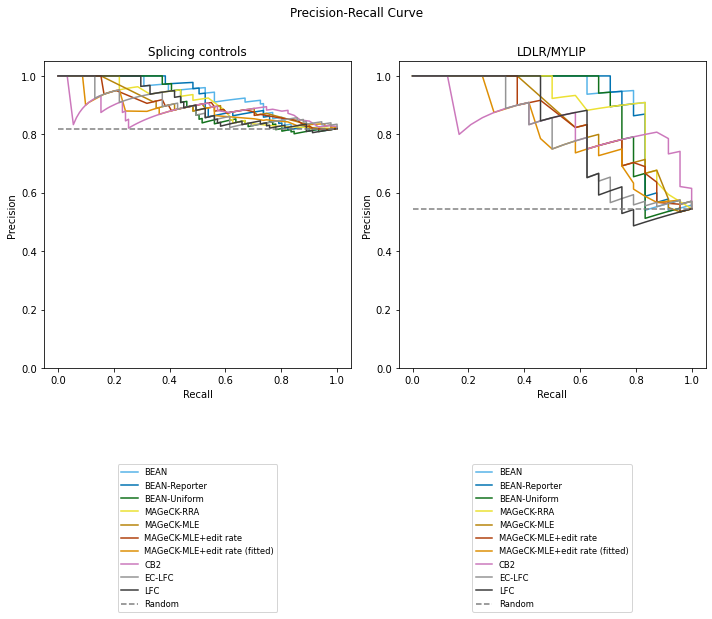

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
auprcs_splicing = draw_prc(scores_tbl, method_label_map_fdr.keys(), method_label_map_fdr, ax[0], title="Splicing controls")
auprcs_lm = draw_prc(scores_tbl, method_label_map_fdr.keys(), method_label_map_fdr, ax[1], title="LDLR/MYLIP", strongest_splicing=True)
handles, labels = ax[0].get_legend_handles_labels()
#fig.legend(loc='center right', bbox_to_anchor=(1.4,0.5), handles=handles, labels=labels, title="method (AUPRC)")
plt.suptitle("Precision-Recall Curve")
plt.tight_layout()
plt.setp(ax, box_aspect=1)
fig.savefig('f_PRC_full.pdf',  bbox_inches='tight')

## 2-replicate combination




In [17]:
def draw_prcs(prefix: str, file_labels: List[str], method_label_map, ax, inverse_score= True, title="", alpha = 0.05, strongest_splicing=False):
    score_tbls = []
    auprc_list = []
    for file_label in file_labels:
        score_tbl = pd.read_csv(prefix.format(file_label))
        score_tbl['nLFC'] = -score_tbl["pos|lfc_rra_bot"]
        score_tbl["nLFC_normed"] = score_tbl["nLFC"]/score_tbl["edit_rate_mean_Normal"]
        score_tbl["fdr_rra_bot"] =score_tbl[["pos|fdr_rra_bot", "neg|fdr_rra_bot"]].min(axis=1)
        score_tbl['min_z_MixtureNormal+Acc'] = -score_tbl['mu_z_MixtureNormal+Acc'].abs()
        score_tbl['min_z_MixtureNormal'] = -score_tbl['mu_z_MixtureNormal'].abs()
        score_tbl['min_z_Normal'] = -score_tbl['mu_z_Normal'].abs()
        score_tbls.append(score_tbl)
        res = draw_prc(score_tbl, method_label_map.keys(), method_label_map, ax, alpha = alpha, strongest_splicing=strongest_splicing, draw_baseline=False)
        auprc_list.append(res)
    ax.get_legend().remove()
    all_scores = pd.concat(score_tbls)
    draw_prc(all_scores, method_label_map.keys(), method_label_map, ax, title=title, strongest_splicing=strongest_splicing, draw_baseline=True)
    res = pd.DataFrame(auprc_list, index=file_labels)
    return res

In [18]:
prefix="../../results/model_runs/{}/all_scores.csv"

In [19]:
comb_dirs=[]
reg_compile = re.compile(r"bean_count_LDLvar_annotated_complete_rep\d*_rep\d*")
for dirname in os.listdir("../../results/model_runs/"):
    if reg_compile.match(dirname):
        comb_dirs.append(dirname)

comb_dirs

['bean_count_LDLvar_annotated_complete_rep5_rep15',
 'bean_count_LDLvar_annotated_complete_rep14_rep15',
 'bean_count_LDLvar_annotated_complete_rep10_rep14',
 'bean_count_LDLvar_annotated_complete_rep5_rep11',
 'bean_count_LDLvar_annotated_complete_rep10_rep15',
 'bean_count_LDLvar_annotated_complete_rep5_rep12',
 'bean_count_LDLvar_annotated_complete_rep11_rep14',
 'bean_count_LDLvar_annotated_complete_rep10_rep12',
 'bean_count_LDLvar_annotated_complete_rep11_rep12',
 'bean_count_LDLvar_annotated_complete_rep5_rep14',
 'bean_count_LDLvar_annotated_complete_rep12_rep15',
 'bean_count_LDLvar_annotated_complete_rep5_rep10',
 'bean_count_LDLvar_annotated_complete_rep12_rep14',
 'bean_count_LDLvar_annotated_complete_rep10_rep11',
 'bean_count_LDLvar_annotated_complete_rep11_rep15']

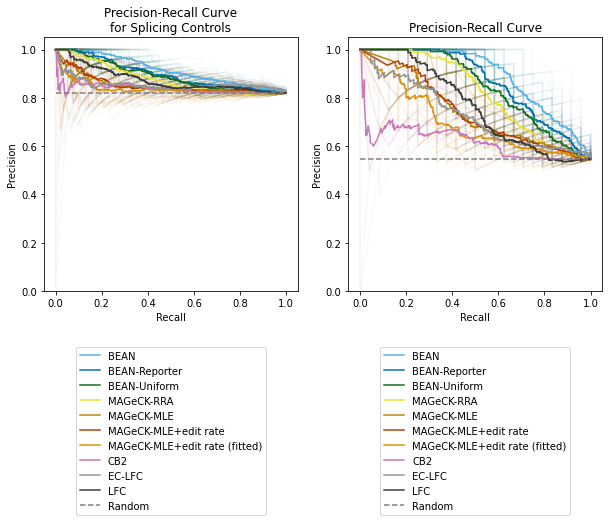

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
auprcs_subsamples = draw_prcs(prefix, comb_dirs, method_label_map_fdr, ax[0], title="Precision-Recall Curve\nfor Splicing Controls")
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(loc = "upper center", bbox_to_anchor=(0.5,-0.2), handles=handles[-len(method_label_map_fdr.keys())-1:],
         labels=labels[-len(method_label_map_fdr.keys())-1:])

auprcs_subsamples_lm = draw_prcs(prefix, comb_dirs, method_label_map_fdr, ax[1], title="Precision-Recall Curve", strongest_splicing=True)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(loc = "upper center", bbox_to_anchor=(0.5,-0.2), handles=handles[-len(method_label_map_fdr.keys())-1:],
         labels=labels[-len(method_label_map_fdr.keys())-1:])
ax[1].set_box_aspect(1)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
fig.savefig('f_PRC_2reps_ldlr_mylip.pdf',  bbox_inches='tight')

In [21]:
auprcs_subsamples = auprcs_subsamples.melt(var_name='method', value_name='AUPRC')
auprcs_subsamples_lm = auprcs_subsamples_lm.melt(var_name='method', value_name='AUPRC')

In [22]:
auprcs_splicing = pd.DataFrame({"method":auprcs_splicing.keys(), "AUPRC":auprcs_splicing.values()})
auprcs_lm = pd.DataFrame({"method":auprcs_lm.keys(), "AUPRC":auprcs_lm.values()})

In [23]:
# save data table
auprcs_subsamples['group'] = 'replicate subsamples'
auprcs_subsamples['positive_controls'] = 'all splicing'
auprcs_subsamples_lm['group'] = 'replicate subsamples'
auprcs_subsamples_lm['positive_controls'] = 'LDLR, MYLIP'
auprcs_splicing['group'] = 'all replicates'
auprcs_splicing['positive_controls'] = 'all splicing'
auprcs_lm['group'] = 'all replicates'
auprcs_lm['positive_controls'] = 'LDLR, MYLIP'
pd.concat([auprcs_subsamples, auprcs_subsamples_lm, auprcs_splicing, auprcs_lm]).to_csv("Figure3_AUPRC_data.csv")

In [24]:
#https://stackoverflow.com/questions/61647192/boxplot-and-data-points-side-by-side-in-one-plot
def move_scatter(ax):
    path_collections = [child for child in ax.get_children() 
                    if isinstance(child,matplotlib.collections.PathCollection)] 

    for path_collection in path_collections: 
        x,y = np.array(path_collection.get_offsets()).T 
        if len(x) == 0: continue
        xnew = x -0.5
        offsets = list(zip(xnew,y)) 
        path_collection.set_offsets(offsets)

In [25]:
auprcs_subsamples_lm.groupby("method").mean()

<ipython-input-25-69f3f4f67962>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  auprcs_subsamples_lm.groupby("method").mean()


,AUPRC
method,
BEAN,0.899104
BEAN-Reporter,0.870291
BEAN-Uniform,0.851467
CB2,0.634086
EC-LFC,0.742965
LFC,0.772422
MAGeCK-MLE,0.750059
MAGeCK-MLE+edit rate,0.749762
MAGeCK-MLE+edit rate (fitted),0.708351


In [36]:
auprcs_lm

,method,AUPRC,group,positive_controls
0,BEAN,0.913107,all replicates,"LDLR, MYLIP"
1,BEAN-Reporter,0.918628,all replicates,"LDLR, MYLIP"
2,BEAN-Uniform,0.894060,all replicates,"LDLR, MYLIP"
3,MAGeCK-RRA,0.900194,all replicates,"LDLR, MYLIP"
4,MAGeCK-MLE,0.836287,all replicates,"LDLR, MYLIP"
5,MAGeCK-MLE+edit rate,0.839781,all replicates,"LDLR, MYLIP"
6,MAGeCK-MLE+edit rate (fitted),0.799365,all replicates,"LDLR, MYLIP"
7,CB2,0.840294,all replicates,"LDLR, MYLIP"
8,EC-LFC,0.799533,all replicates,"LDLR, MYLIP"
9,LFC,0.813953,all replicates,"LDLR, MYLIP"


In [26]:
0.896794/0.815163

1.100140708054708

In [27]:
0.896794/0.772422

1.1610156106377083

In [28]:
plt.style.use('jr')

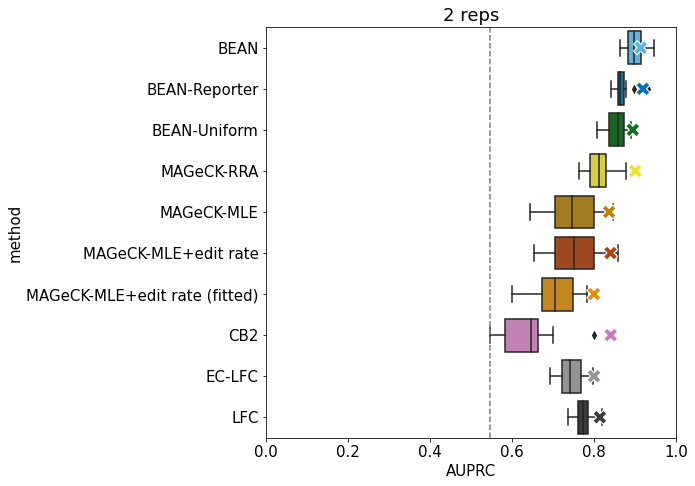

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(auprcs_subsamples_lm.loc[auprcs_subsamples_lm.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", palette = method_pal_ext, ax = ax, orient='h')
ax.axvline(auprcs_lm.loc[auprcs_lm.method == 'baseline', "AUPRC"].item(), linestyle = '--', color = 'grey')
sns.scatterplot(auprcs_lm.loc[auprcs_lm.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", hue='method', palette = method_pal_ext, ax = ax, s = 200, marker='X',zorder=100)
ax.get_legend().remove()
ax.set_xlim((0,1))
ax.set_title("2 reps")
plt.setp(ax, box_aspect=1)
plt.tight_layout()
fig.savefig("AUPRC_horizontal_LM_all_and_subsamples_single.pdf", bbox_inches="tight")

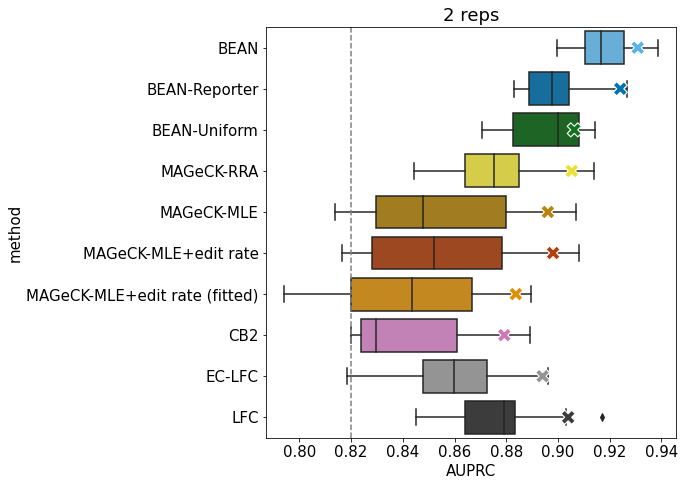

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(auprcs_subsamples.loc[auprcs_subsamples.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", palette = method_pal_ext, ax = ax, orient='h')
ax.axvline(auprcs_splicing.loc[auprcs_splicing.method == 'baseline', "AUPRC"].item(), linestyle = '--', color = 'grey')
sns.scatterplot(auprcs_splicing.loc[auprcs_splicing.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", hue='method', palette = method_pal_ext, ax = ax, s = 200, marker='X',zorder=100)
ax.get_legend().remove()
ax.set_title("2 reps")
plt.setp(ax, box_aspect=1)
plt.tight_layout()
fig.savefig("AUPRC_horizontal_all_and_subsamples_single.pdf", bbox_inches="tight")

<ipython-input-31-5a9276010695>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(


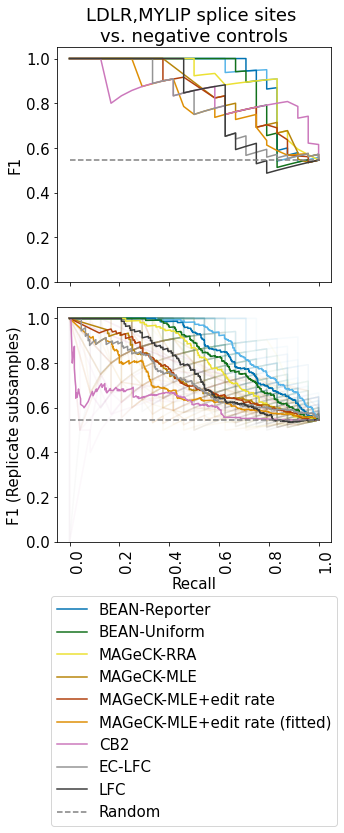

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(5, 12), sharex=True)
res = draw_prc(scores_tbl, method_label_map_fdr.keys(), method_label_map_fdr, ax[0], title="LDLR/MYLIP", strongest_splicing=True)
ax[0].set_xlabel("")
ax[0].set_ylabel("F1")
subsample_res = draw_prcs(prefix, comb_dirs, method_label_map_fdr, ax[1], title="Precision-Recall Curve", strongest_splicing=True)
ax[0].get_legend().remove()
ax[1].set_xticklabels(
    labels=ax[1].get_xticklabels(),   
    rotation=90,         
    ha="right",  
    rotation_mode="anchor")
ax[1].set_ylabel("F1 (Replicate subsamples)")
ax[0].set_title("LDLR,MYLIP splice sites \nvs. negative controls")
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(loc = "upper center", bbox_to_anchor=(0.5,-0.2), handles=handles[-len(method_label_map_fdr.keys()):],
         labels=labels[-len(method_label_map_fdr.keys()):])
ax[1].set_title("")
plt.tight_layout()
fig.savefig("Fig3d_AUPRC_LDLR_MYLIP.pdf")

In [32]:
pd.Series(res)

BEAN                             0.913107
BEAN-Reporter                    0.918628
BEAN-Uniform                     0.894060
MAGeCK-RRA                       0.900194
MAGeCK-MLE                       0.836287
MAGeCK-MLE+edit rate             0.839781
MAGeCK-MLE+edit rate (fitted)    0.799365
CB2                              0.840294
EC-LFC                           0.799533
LFC                              0.813953
baseline                         0.545455
dtype: float64

In [33]:
subsample_res.mean(axis=0)

BEAN                             0.899104
BEAN-Reporter                    0.870291
BEAN-Uniform                     0.851467
MAGeCK-RRA                       0.815163
MAGeCK-MLE                       0.750059
MAGeCK-MLE+edit rate             0.749762
MAGeCK-MLE+edit rate (fitted)    0.708351
CB2                              0.634086
EC-LFC                           0.742965
LFC                              0.772422
dtype: float64

In [34]:
auprc_tbl = pd.concat([pd.Series(res), subsample_res.mean(axis=0)], axis=1).reset_index()
auprc_tbl.columns=["method", "LDLvar", "Replicate subsamples"]
auprc_tbl = sort_df(auprc_tbl, method_pal.keys())

In [35]:
auprc_tbl.set_index("method").iloc[:,:2].round(3)

,LDLvar,Replicate subsamples
method,,
BEAN,0.913,0.899
BEAN-Reporter,0.919,0.870
BEAN-Uniform,0.894,0.851
MAGeCK-RRA,0.900,0.815
MAGeCK-MLE,0.836,0.750
MAGeCK-MLE+edit rate,0.840,0.750
MAGeCK-MLE+edit rate (fitted),0.799,0.708
CB2,0.840,0.634
EC-LFC,0.800,0.743
